# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,2.136180,True,7.803248
1,1.708013,True,8.609767
2,0.387531,True,6.071246
3,-0.073044,False,0.732576
4,0.408200,False,1.728948
...,...,...,...
995,0.033866,False,-1.659663
996,1.463312,True,7.621977
997,0.049412,False,1.200057
998,-0.907189,False,-2.643674


<AxesSubplot:xlabel='v0'>

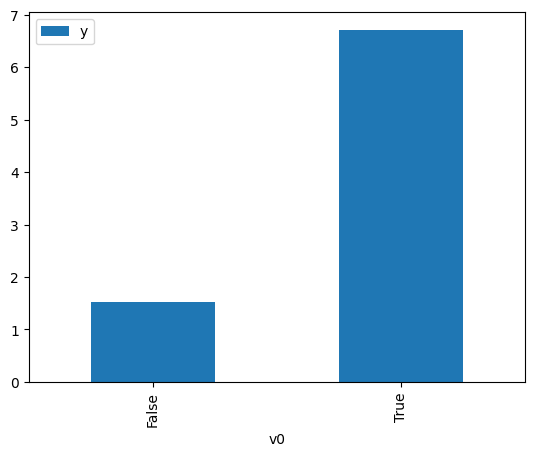

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

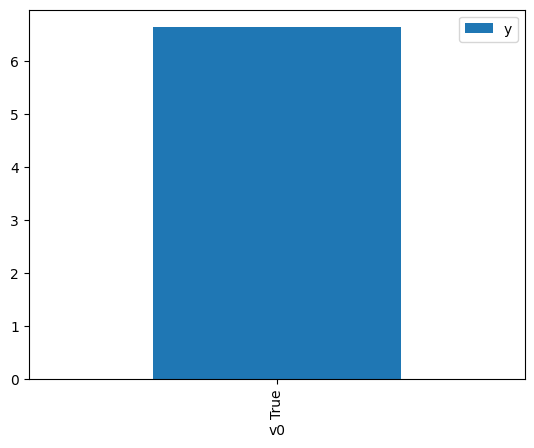

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.356275,False,-2.405975,0.635965,1.572414
1,2.273736,False,5.247081,0.049246,20.306178
2,-0.655499,False,-1.506824,0.722758,1.383589
3,-1.313484,False,-1.589285,0.862760,1.159071
4,0.878017,False,1.768048,0.250999,3.984080
...,...,...,...,...,...
995,0.080819,False,1.711220,0.493292,2.027197
996,2.273736,False,5.247081,0.049246,20.306178
997,1.630578,False,2.183442,0.109093,9.166456
998,0.435961,False,1.936218,0.377088,2.651902


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.147530,True,6.613925,0.810588,1.233673
1,1.037683,True,8.316472,0.786992,1.270662
2,-0.240182,True,3.279081,0.400691,2.495692
3,0.856792,True,5.484787,0.743625,1.344763
4,1.739718,True,8.809481,0.904308,1.105818
...,...,...,...,...,...
995,0.086366,True,4.555544,0.508563,1.966326
996,0.387531,True,6.071246,0.607577,1.645881
997,-0.560397,True,4.002027,0.303442,3.295518
998,-1.281904,True,3.342529,0.142319,7.026464


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.975
Model:                            OLS   Adj. R-squared (uncentered):              0.975
Method:                 Least Squares   F-statistic:                          1.933e+04
Date:                Wed, 07 Sep 2022   Prob (F-statistic):                        0.00
Time:                        08:23:34   Log-Likelihood:                         -1428.1
No. Observations:                1000   AIC:                                      2860.
Df Residuals:                     998   BIC:                                      2870.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.1558      0.037     58.764      0.000       2.084       2.228
x2             5.0033      0.056     89.858      0.000       4.894       5.113
==============================================================================
Omnibus:                        0.972   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.615   Jarque-Bera (JB):                0.846
Skew:                          -0.055   Prob(JB):                        0.655
Kurtosis:                       3.090   Cond. No.                         2.74
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""